In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

import numpy as np
from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

Import the dataset:

In [ ]:
dataset = datasets.PubMedDiabetes()

G, _ = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [ ]:
# train, test, validation split
train_size = 0.5 
val_size = 0.05
test_size = 0.05


edge_splitter_test = EdgeSplitter(G)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_size, method="global", keep_connected=True)

edge_splitter_val = EdgeSplitter(G_test)

G_val, edge_ids_val, edge_labels_val = edge_splitter_val.train_test_split(
    p=val_size, method="global", keep_connected=True)

edge_splitter_train = EdgeSplitter(G_val)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=train_size, method="global", keep_connected=True)

** Sampled 2216 positive and 2216 negative edges. **
** Sampled 2106 positive and 2106 negative edges. **
** Sampled 20008 positive and 20008 negative edges. **


Train the model:

In [ ]:
epochs = 100

train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

val_gen = FullBatchLinkGenerator(G_val, method="gcn")
val_flow = val_gen.flow(edge_ids_val, edge_labels_val)

test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

gcn = GCN(layer_sizes=[10,16,32,64,16,8,64,512], 
          activations=["softmax","relu","relu","elu","relu","softmax","elu","relu"], generator=train_gen, dropout=0.3)

x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),loss=keras.losses.binary_crossentropy,metrics=["binary_accuracy"],)
reduce_lr = ReduceLROnPlateau(monitor='binary_accuracy', factor=0.9, patience=1, min_lr=0.00001)
early_stop = EarlyStopping(monitor='binary_accuracy', patience=5)

history = model.fit(
    train_flow,steps_per_epoch = len(train_flow), epochs=epochs,callbacks=[early_stop, reduce_lr], validation_data=val_flow, validation_steps = len(val_flow), verbose=2, shuffle=True)

Epoch 1/100
1/1 - 6s - loss: 0.9462 - binary_accuracy: 0.5072 - val_loss: 0.7644 - val_binary_accuracy: 0.5408 - lr: 5.0000e-04 - 6s/epoch - 6s/step
Epoch 2/100
1/1 - 2s - loss: 0.8844 - binary_accuracy: 0.5136 - val_loss: 0.7045 - val_binary_accuracy: 0.5605 - lr: 5.0000e-04 - 2s/epoch - 2s/step
Epoch 3/100
1/1 - 2s - loss: 0.8262 - binary_accuracy: 0.5214 - val_loss: 0.6494 - val_binary_accuracy: 0.5888 - lr: 5.0000e-04 - 2s/epoch - 2s/step
Epoch 4/100
1/1 - 1s - loss: 0.7670 - binary_accuracy: 0.5370 - val_loss: 0.5999 - val_binary_accuracy: 0.6223 - lr: 5.0000e-04 - 1s/epoch - 1s/step
Epoch 5/100
1/1 - 1s - loss: 0.7244 - binary_accuracy: 0.5540 - val_loss: 0.5568 - val_binary_accuracy: 0.6581 - lr: 5.0000e-04 - 784ms/epoch - 784ms/step
Epoch 6/100
1/1 - 1s - loss: 0.6840 - binary_accuracy: 0.5792 - val_loss: 0.5268 - val_binary_accuracy: 0.7011 - lr: 5.0000e-04 - 778ms/epoch - 778ms/step
Epoch 7/100
1/1 - 1s - loss: 0.6483 - binary_accuracy: 0.6094 - val_loss: 0.5024 - val_binary_

Plot the training history:

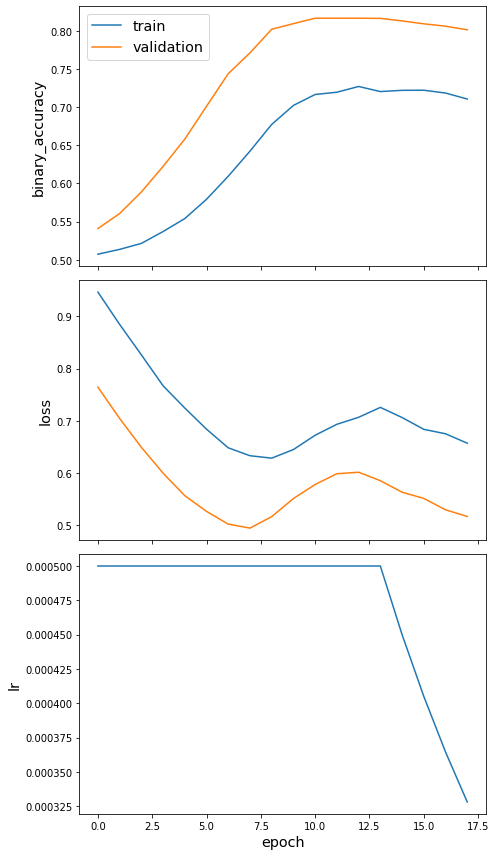

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model:

In [ ]:
train_metrics = model.evaluate(train_flow)
val_metrics = model.evaluate(val_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 189ms/step - loss: 0.5195 - binary_accuracy: 0.8098

Train Set Metrics of the trained model:
	loss: 0.6273
	binary_accuracy: 0.7078

Validation Set Metrics of the trained model:
	loss: 0.5171
	binary_accuracy: 0.8013

Test Set Metrics of the trained model:
	loss: 0.5195
	binary_accuracy: 0.8098
